In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
#import statsmodels.api as sm
#import statsmodels.stats.api as sms
#import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression, Lasso
#from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import scale
#from sklearn.model_selection import cross_val_score
from sklearn.cross_validation import cross_val_score
#from statsmodels.stats.outliers_influence import variance_inflation_factor
import sklearn.metrics

%matplotlib inline

In [8]:
import sys
sys.path.insert(0, './src')

import data_clean as dclean

In [44]:
df_train_all = pd.read_csv('data/Train.csv')

In [45]:
df_test_all = pd.read_csv('data/Test.csv')

In [46]:
df_train_all['saleyear'] =  pd.to_datetime(df_train_all['saledate']).dt.year.values

## General Data Cleaning

**Check Null values**

In [12]:
dclean.check_nan(df_train_all, df_train_all.columns)

Dataframe total row count:  401125
auctioneerID  has  20136 null/NAN values
MachineHoursCurrentMeter  has  258360 null/NAN values
UsageBand  has  331486 null/NAN values
fiSecondaryDesc  has  137191 null/NAN values
fiModelSeries  has  344217 null/NAN values
fiModelDescriptor  has  329206 null/NAN values
ProductSize  has  210775 null/NAN values
Drive_System  has  296764 null/NAN values
Enclosure  has  325 null/NAN values
Forks  has  209048 null/NAN values
Pad_Type  has  321991 null/NAN values
Ride_Control  has  252519 null/NAN values
Stick  has  321991 null/NAN values
Transmission  has  217895 null/NAN values
Turbocharged  has  321991 null/NAN values
Blade_Extension  has  375906 null/NAN values
Blade_Width  has  375906 null/NAN values
Enclosure_Type  has  375906 null/NAN values
Engine_Horsepower  has  375906 null/NAN values
Hydraulics  has  80555 null/NAN values
Pushblock  has  375906 null/NAN values
Ripper  has  296988 null/NAN values
Scarifier  has  375895 null/NAN values
Tip_Control  

In [14]:
# Select all numerical features into a new dataframe
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df_numeric = df_train_all.select_dtypes(include=numerics)
## Or
# df_numeric = df.select_dtypes(exclude=[object])

In [17]:
df_numeric.columns

Index([u'SalesID', u'SalePrice', u'MachineID', u'ModelID', u'datasource',
       u'auctioneerID', u'YearMade', u'MachineHoursCurrentMeter'],
      dtype='object')

**Check 0 values in numeric columns**

In [28]:
dclean.check_zero(df_numeric, df_numeric.columns)

Dataframe total row count:  401125
Column MachineID : 2 rows are 0
Column auctioneerID : 407 rows are 0
Column MachineHoursCurrentMeter : 73126 rows are 0


**Drop columns that has large portion of NaN values in train and test sets**

In [47]:
df_train_orig, drop_cols = dclean.drop_NaN_cols(df_train_all, 0.7)
df_test_orig = df_test_all.drop(drop_cols, axis=1)

In [48]:
print ', '.join(drop_cols)

UsageBand, fiModelSeries, fiModelDescriptor, Drive_System, Pad_Type, Stick, Turbocharged, Blade_Extension, Blade_Width, Enclosure_Type, Engine_Horsepower, Pushblock, Ripper, Scarifier, Tip_Control, Tire_Size, Coupler_System, Grouser_Tracks, Hydraulics_Flow, Track_Type, Undercarriage_Pad_Width, Stick_Length, Thumb, Pattern_Changer, Grouser_Type, Backhoe_Mounting, Blade_Type, Travel_Controls, Differential_Type, Steering_Controls


In [49]:
df_train_orig.columns

Index([u'SalesID', u'SalePrice', u'MachineID', u'ModelID', u'datasource',
       u'auctioneerID', u'YearMade', u'MachineHoursCurrentMeter', u'saledate',
       u'fiModelDesc', u'fiBaseModel', u'fiSecondaryDesc', u'ProductSize',
       u'fiProductClassDesc', u'state', u'ProductGroup', u'ProductGroupDesc',
       u'Enclosure', u'Forks', u'Ride_Control', u'Transmission', u'Hydraulics',
       u'Coupler', u'saleyear'],
      dtype='object')

**After doing some research, pick first set of features from columns above**

In [123]:
cols = ['YearMade', 'MachineHoursCurrentMeter', 'saleyear', 'SalePrice', 'ModelID']
df_train_0 = df_train_orig[cols]

In [124]:
#df_train_0.head()

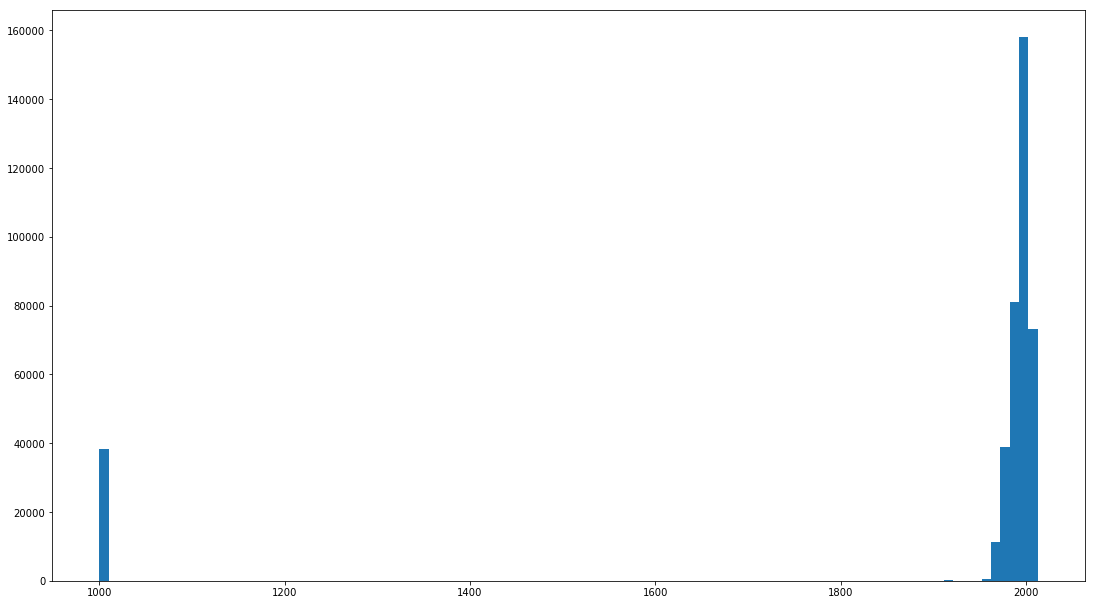

In [125]:
# Plot features
fig, ax = plt.subplots()
ax.hist(df_train_0['YearMade'], bins=100)
fig.set_size_inches(18.5, 10.5, forward=True)
fig.show()

**Plot shows invalid values in YearMade, removing them**

In [126]:
df_train_0.drop(df_train_0[df_train_0['YearMade']<1960].index, axis=0, inplace=True)

/Users/ziru/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


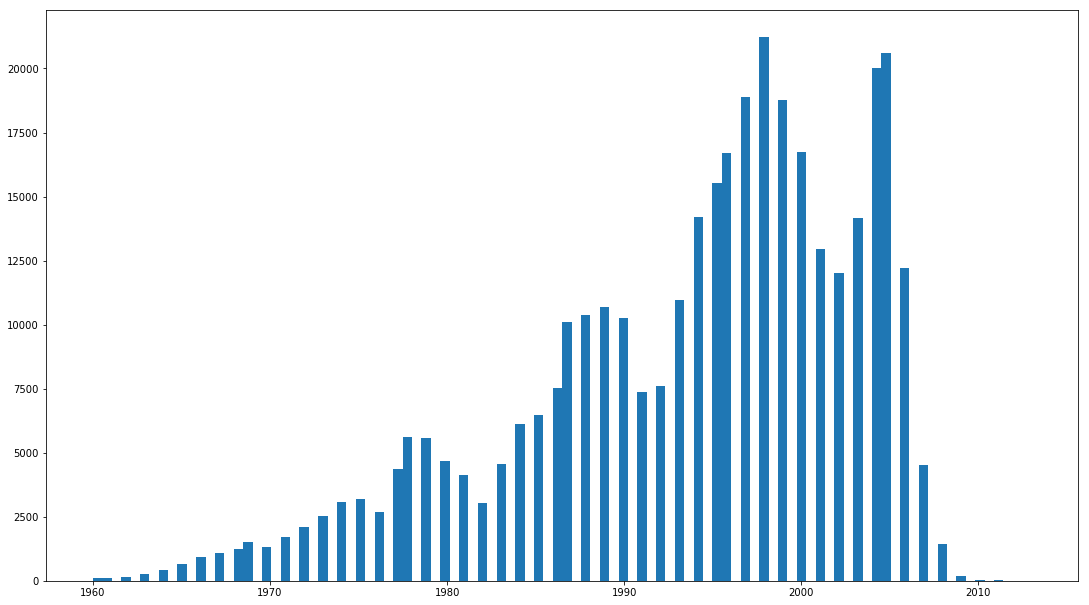

In [127]:
fig, ax = plt.subplots()
ax.hist(df_train_0['YearMade'], bins=100)
fig.set_size_inches(18.5, 10.5, forward=True)
fig.show()

**From YearMade and saleyear, make MachineAge**

In [128]:
df_train_0['MachineAge'] = df_train_0['saleyear'] - df_train_0['YearMade']

/Users/ziru/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


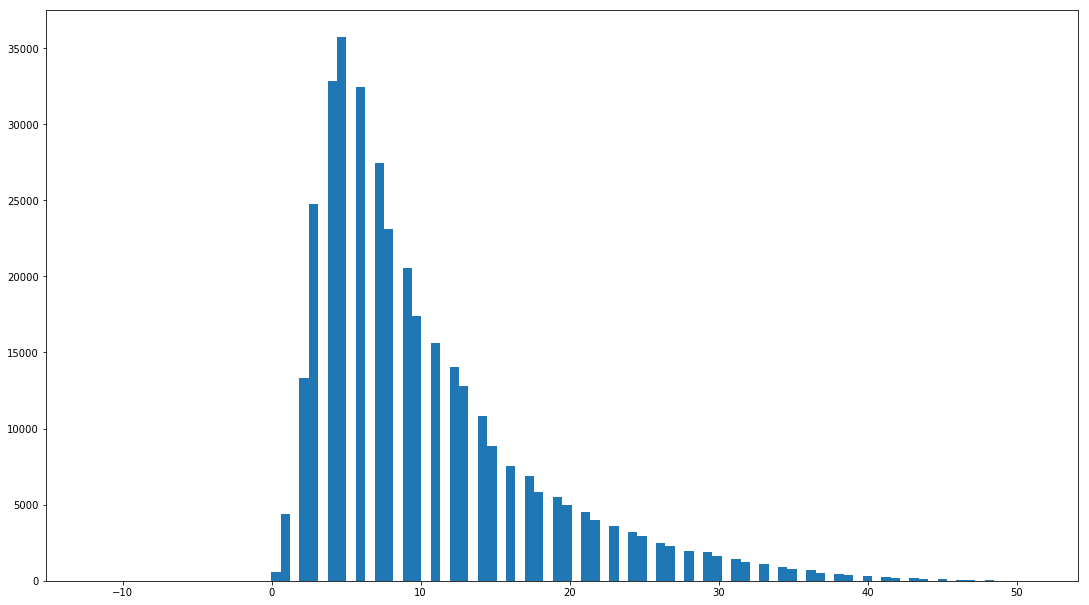

In [129]:
fig, ax = plt.subplots()
ax.hist(df_train_0['MachineAge'], bins=100)
fig.set_size_inches(18.5, 10.5, forward=True)
fig.show()

In [130]:
df_train_0.drop(df_train_0[df_train_0['MachineAge']<0].index, axis=0, inplace=True)

/Users/ziru/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


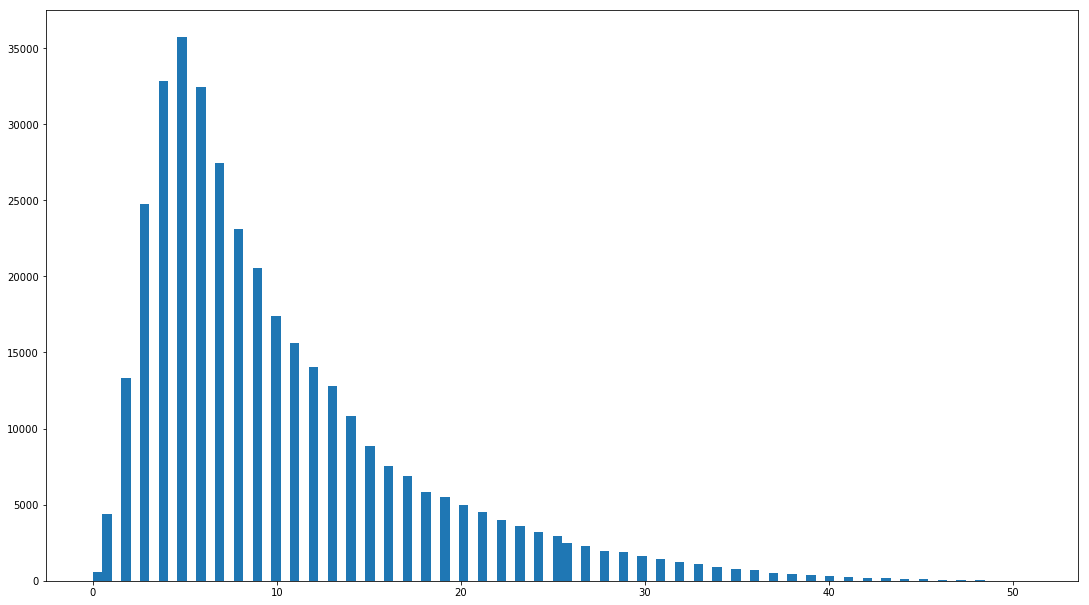

In [131]:
fig, ax = plt.subplots()
ax.hist(df_train_0['MachineAge'], bins=100)
fig.set_size_inches(18.5, 10.5, forward=True)
fig.show()

In [132]:
dclean.check_nan(df_train_0, cols)

Dataframe total row count:  362656
MachineHoursCurrentMeter  has  236430 null/NAN values
There are 1 columns with nan/null values


**There are a large portion of NaN values in MachineHoursCurrentMeter, because the data volume is large even we remove all rows with NaN values in this column, we can just do that. Another way of fixing it is by filling artificial values**

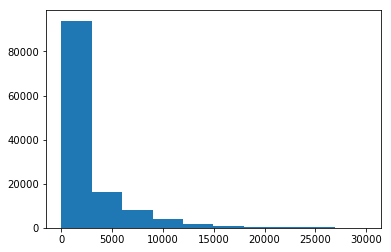

In [134]:
# Check column value distribution
meter_check = df_train_0[df_train_0['MachineHoursCurrentMeter'].notnull()]
plt.hist(meter_check[meter_check['MachineHoursCurrentMeter']<30000]['MachineHoursCurrentMeter'])
plt.show()

In [135]:
meter_check[meter_check['MachineHoursCurrentMeter']<30000]['MachineHoursCurrentMeter'].describe()

count    125599.000000
mean       2196.802323
std        3649.181950
min           0.000000
25%           0.000000
50%         152.000000
75%        3025.000000
max       29956.000000
Name: MachineHoursCurrentMeter, dtype: float64

**The estimated mean of column MachineHoursCurrentMeter is around 5121, therefore:**

In [136]:
df_train_0['MachineHoursCurrentMeter']=df_train_0['MachineHoursCurrentMeter'].fillna(5121)

/Users/ziru/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [137]:
dclean.check_nan(df_train_0, cols)

Dataframe total row count:  362656
There are 0 columns with nan/null values


**Now dataframe looks clean**

In [138]:
df_train_0.head()

,YearMade,MachineHoursCurrentMeter,saleyear,SalePrice,ModelID,MachineAge
0,2004,68.0,2006,66000,3157,2
1,1996,4640.0,2004,57000,77,8
2,2001,2838.0,2004,10000,7009,3
3,2001,3486.0,2011,38500,332,10
4,2007,722.0,2009,11000,17311,2


## Simple Modeling

**Check null mae**

In [141]:
y_mean= np.full((len(y_test), 1), y_test.mean(), dtype=np.int)

In [142]:
sklearn.metrics.mean_absolute_error(y_test, y_mean)

17903.955042795376

**Modeling**

In [139]:
X = df_train_0[df_train_0.drop(['SalePrice','ModelID'], axis =1).columns]
X_scale = scale(X)
y = df_train_0['SalePrice']
lreg = LinearRegression()
#lreg.fit(X_scale, y)
#y_pred = lreg.predict(X_scale)
print cross_val_score(lreg, X_scale, y, cv = 5, scoring = 'mean_absolute_error')

[-17035.08274818 -17574.71180456 -16407.94593995 -19924.83435165
 -18112.76640182]


**Plot mses for Lasso modeling**

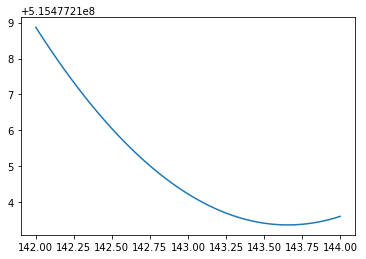

In [134]:
alphas = np.linspace(142, 144, 100)
mses = []
for a in alphas:
    clf = Lasso(alpha=a)
    clf.fit(X_train_scale, y_train)
    y_pred = clf.predict(X_test_scale)
    mse = sklearn.metrics.mean_squared_error(y_test, y_pred)
    mses.append(mse)

plt.plot(alphas, mses)
    

In [137]:
clf = Lasso(alpha=143.6)
clf.fit(X_train_scale, y_train)
y_pred_143 = clf.predict(X_test_scale)

In [138]:
sklearn.metrics.mean_absolute_error(y_test, y_pred_143)

17335.131054167232

**Plot residual**

In [143]:
std_residual = (y_test-y_pred_143)/np.std((y_pred_143-y_test))

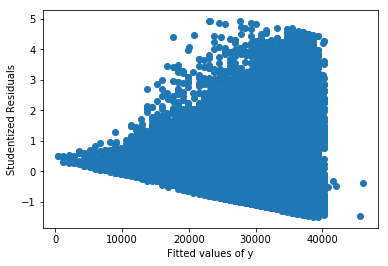

In [145]:
plt.scatter(y_pred_143, std_residual)
plt.xlabel('Fitted values of y')
plt.ylabel('Studentized Residuals')

**Do a log transform on y, check log(y)'s distribution**

(array([  1208.,   5481.,  10873.,  13579.,  15732.,  16013.,  11894.,
          8522.,   5874.,   1488.]),
 array([  8.4658999 ,   8.80566814,   9.14543638,   9.48520463,
          9.82497287,  10.16474112,  10.50450936,  10.8442776 ,
         11.18404585,  11.52381409,  11.86358234]),
 <a list of 10 Patch objects>)

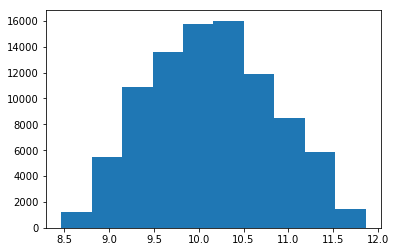

In [151]:
plt.hist(np.log(y_test))

**After log transform, log(y) is more normally distributed**

**Modeling using log(y) as the target**

In [90]:
clf = Lasso(alpha=0.0000001)
y_train_log = y_train.apply(np.log)
clf.fit(X_train_scale, y_train_log)
y_pred_143 = clf.predict(X_test_scale)

In [173]:
std_residual = (np.log(y_test)-y_pred_143)/np.std((y_pred_143-np.log(y_test)))

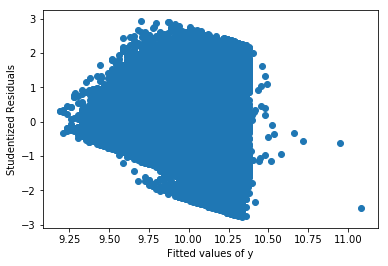

In [174]:
plt.scatter(y_pred_143, std_residual)
plt.xlabel('Fitted values of y')
plt.ylabel('Studentized Residuals')

In [92]:
y_pred_real = np.e**(y_pred_143)

In [93]:
y_pred_real

array([ 28634.80997339,  24926.95872333,  28634.80997339, ...,
        29262.75368397,  27980.58586216,  27980.58586216])

In [94]:
sklearn.metrics.mean_absolute_error(y_test, y_pred_real)

16345.190284368351

## Explore new feature

**Because each modelID matches with an original price, a mean salesprice for each model could potential be a useful feature**

In [140]:
df_new_tracs = df_train_0[df_train_0['saleyear']>2000]
d_price = df_new_tracs.groupby('ModelID')['SalePrice'].mean().to_frame().reset_index().sort('SalePrice',ascending=False)
d_count = df_new_tracs.groupby('ModelID').size().to_frame().reset_index().rename(columns={0:'count'}).sort('count',ascending=False)

/Users/ziru/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  
/Users/ziru/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  This is separate from the ipykernel package so we can avoid doing imports until


In [141]:
#d_price = df_train_numeric.groupby('ModelID')['SalePrice'].mean().to_frame().reset_index()

In [142]:
d_price.rename(columns={'SalePrice':'model_mean_price'}, inplace=True)

In [143]:
df_train_1 = df_train_0.join(d_price.set_index('ModelID'), on='ModelID', lsuffix='_orig', rsuffix='_meanprice')

In [144]:
df_train_1.dropna(how='any', inplace=True)

In [145]:
dclean.check_nan(df_train_2, df_train_2.columns)#.head()

Dataframe total row count:  360679
There are 0 columns with nan/null values


**Modeling using new feature model_mean_price**

In [120]:
X = df_train_2[['MachineHoursCurrentMeter','MachineAge','model_mean_price']]
#X = df_new_new[['MachineAge','YearMade','model_mean_price']]
X_scale = scale(X)
y = df_train_2['SalePrice']
lreg = LinearRegression()
#lreg.fit(X_scale, y)
#y_pred = lreg.predict(X_scale)
print cross_val_score(lreg, X_scale, y, cv = 5, scoring = 'mean_absolute_error')

[ -7805.17321185 -10010.67216754  -7531.57815271  -8272.00858704
  -9019.1683665 ]


**mae decreased significantly**